In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [4]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [5]:
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [6]:
# 파라미터 설정
batch_size = 50
learning_rate = 0.0001
epoch = 15

In [8]:
!sudo pip3 install torchvision --upgrade

     |████████████████████████████████| 23.3 MB 1.4 MB/s 
     |████████████████████████████████| 881.9 MB 16 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.10.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.10.1 which is incompatible.


In [9]:
!pip install --upgrade --force-reinstall --no-deps albumentations

     |████████████████████████████████| 102 kB 5.3 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [11]:
train_data = datasets.MNIST(root='./data',
                            train=True,
                            download = True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
len(train_data), len(test_data)

(60000, 10000)

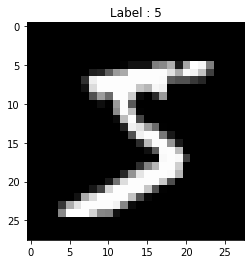

In [13]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('Label : %s' % label)
plt.show()

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [15]:
first_batch = train_loader.__iter__().__next__()

In [16]:
len(train_loader)

1200

In [17]:
type(first_batch)

list

In [18]:
first_batch[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [19]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
    self.dropout = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(3136, 1000)
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.dropout(x)
    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    output = F.log_softmax(x, dim=1)

    return output

In [20]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [22]:
model.train()
i = 1
epoch_num = 15
for epoch in range(epoch_num):
  for data, target in train_loader:
    data= data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
      print(i, loss.item)
    
    i += 1

1000 <built-in method item of Tensor object at 0x7faa9669d410>
2000 <built-in method item of Tensor object at 0x7faa9669d890>
3000 <built-in method item of Tensor object at 0x7faa966841d0>
4000 <built-in method item of Tensor object at 0x7faa96684530>
5000 <built-in method item of Tensor object at 0x7faa966843b0>
6000 <built-in method item of Tensor object at 0x7faa9669db90>
7000 <built-in method item of Tensor object at 0x7faa9669ddd0>
8000 <built-in method item of Tensor object at 0x7faa9669ddd0>
9000 <built-in method item of Tensor object at 0x7faa96684590>
10000 <built-in method item of Tensor object at 0x7faa96684ef0>
11000 <built-in method item of Tensor object at 0x7faa9669d470>
12000 <built-in method item of Tensor object at 0x7faa9669de30>
13000 <built-in method item of Tensor object at 0x7faa96684590>
14000 <built-in method item of Tensor object at 0x7faa966845f0>
15000 <built-in method item of Tensor object at 0x7faa966849b0>
16000 <built-in method item of Tensor object at 0

In [23]:
model.eval()

correct = 0

for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = model(data)
  prediction = output.data.max(1)[1]
  correct += prediction.eq(target.data).sum()

print(correct/10000)

tensor(0.9908, device='cuda:0')
